`EM`-based optimization of GMM, with optimal parameters estimations. 

Convergence reached at iteration 10.
Estimated mixing weights: [0.50157695 0.49842305]
Estimated means: [ 3.00632431 -2.00724916]
Estimated variances: [1.01948051 0.22141742]


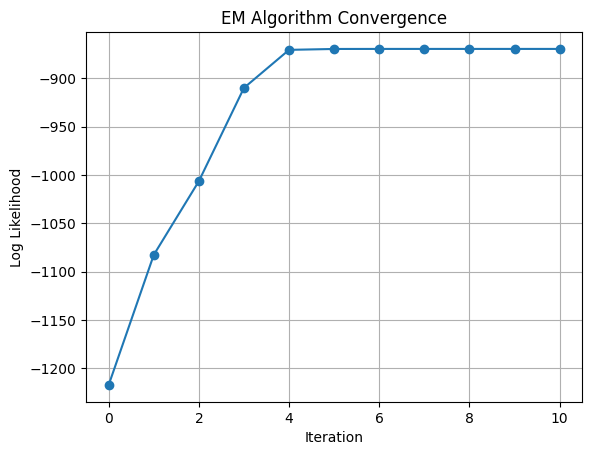

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_pdf(x, mean, var):
    """
    Compute the probability density function of a 1D Gaussian.
    Parameters:
    x (array-like): Data points.
    mean (float): Mean of the Gaussian.
    var (float): Variance of the Gaussian.
    Returns:
    array-like: Evaluated Gaussian PDF at x.
    """
    coeff = 1.0 / np.sqrt(2 * np.pi * var)
    exponent = - ((x - mean) ** 2) / (2 * var)
    return coeff * np.exp(exponent)

def em_gmm(data, n_components=2, max_iter=100, tol=1e-6):
    """
    Perform the EM algorithm for a 1D Gaussian Mixture Model.
    Parameters:
    data (array-like): The observed data (1D).
    n_components (int): Number of Gaussian components.
    max_iter (int): Maximum number of iterations.
    tol (float): Tolerance for convergence (change in log-likelihood).
    Returns:
    weights (array): Estimated mixing weights.
    means (array): Estimated means for each component.
    variances (array): Estimated variances for each component.
    resp (2D array): Final responsibilities matrix.
    log_likelihoods (list): Log-likelihood values over iterations.
    """
    N = len(data)
    
    # Initialize parameters
    weights = np.ones(n_components) / n_components
    means = np.random.choice(data, n_components)
    variances = np.random.random(n_components) * np.var(data)
    
    log_likelihoods = []
    
    for iteration in range(max_iter):
        # E-step: Compute responsibilities for each data point and each component.
        resp = np.zeros((N, n_components))
        for j in range(n_components):
            resp[:, j] = weights[j] * gaussian_pdf(data, means[j], variances[j])
            
        # Normalize the responsibilities so that each row sums to 1.
        resp_sum = resp.sum(axis=1, keepdims=True)
        resp = resp / resp_sum
        
        # M-step: Update parameters using the responsibilities.
        Nk = resp.sum(axis=0) # Effective number of data points for each component.
        weights = Nk / N # Update mixing weights.
        
        for j in range(n_components):
            means[j] = np.sum(resp[:, j] * data) / Nk[j]
            variances[j] = np.sum(resp[:, j] * (data - means[j]) ** 2) / Nk[j]
        
        # Compute the log-likelihood for convergence monitoring.
        log_likelihood = np.sum(np.log(resp_sum))
        log_likelihoods.append(log_likelihood)
        # Check for convergence.
        if iteration > 0:
            if np.abs(log_likelihood - log_likelihoods[-2]) < tol:
                print(f'Convergence reached at iteration {iteration}.')
                break
    return weights, means, variances, resp, log_likelihoods

# --- Generate Synthetic Data ---
np.random.seed(42)
n_samples = 500
# Data from two different Gaussians.
data1 = np.random.normal(loc=-2, scale=0.5, size=n_samples // 2)
data2 = np.random.normal(loc=3, scale=1.0, size=n_samples // 2)
data = np.hstack([data1, data2])
np.random.shuffle(data)

# --- Run the EM Algorithm ---
weights, means, variances, resp, log_likelihoods = em_gmm(data, n_components=2, max_iter=100, tol=1e-6)

print("Estimated mixing weights:", weights)
print("Estimated means:", means)
print("Estimated variances:", variances)

# --- Plot the Log-Likelihood to Check Convergence ---
plt.plot(log_likelihoods, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
plt.title("EM Algorithm Convergence")
plt.grid(True)
plt.show()

`torch` implementation using gradient descent

Iteration 0: Loss = 1709.922
Iteration 500: Loss = 880.964
Iteration 1000: Loss = 880.964
Iteration 1500: Loss = 880.964

Final mixing weights: [0.49993497 0.500065  ]
Final means: [-1.984197   2.9169607]
Final variances: [0.24808988 0.9960219 ]


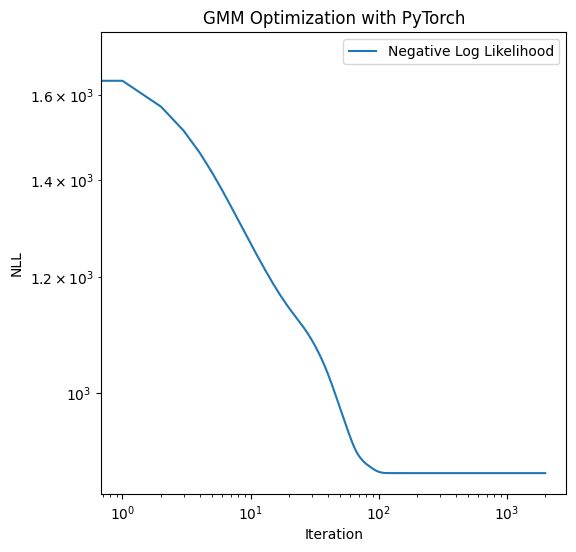

In [3]:
import torch
import torch.nn.functional as F

# --------------------------
# Generate Synthetic Data
# --------------------------
np.random.seed(0)
n_samples = 500
# Generate data from two Gaussians
data1 = np.random.normal(loc=-2, scale=0.5, size=n_samples // 2)
data2 = np.random.normal(loc=3, scale=1.0, size=n_samples // 2)
data = np.concatenate([data1, data2])
data = torch.tensor(data, dtype=torch.float32)

# --------------------------
# Model Parameters
# --------------------------
n_components = 2  # Number of mixture components

# Initialize unconstrained parameters:
# - logits for the mixing weights (will be transformed via softmax)
# - means for each component
# - log_vars for the variances (will be transformed via exp)
logits = torch.randn(n_components, requires_grad=True)
means = torch.randn(n_components, requires_grad=True)
log_vars = torch.randn(n_components, requires_grad=True)

# --------------------------
# Optimizer Setup
# --------------------------
optimizer = torch.optim.Adam([logits, means, log_vars], lr=0.05)
n_iter = 2000  # Number of iterations to optimize
losses = []

# --------------------------
# Optimization Loop
# --------------------------
for i in range(n_iter):
    optimizer.zero_grad()
    
    # Compute mixing weights via softmax to ensure they sum to 1
    weights = F.softmax(logits, dim=0)  # Shape: (K,)
    
    # Compute variances (ensure positivity)
    vars_ = torch.exp(log_vars)  # Shape: (K,)
    
    # Compute the log-likelihood for each data point
    # Expand data to shape (n_samples, 1) for broadcasting
    x = data.unsqueeze(1)  # Shape: (n_samples, 1)
    
    # Compute the Gaussian log density for each mixture component:
    # log N(x; mean, var) = -0.5 * (log(2π * var) + (x - mean)^2 / var)
    diff = x - means.unsqueeze(0)  # Shape: (n_samples, K)
    log_gaussian = -0.5 * (torch.log(2 * torch.pi * vars_) + (diff ** 2) / vars_)  # Shape: (n_samples, K)
    
    # Convert log density back to density values
    gaussian = torch.exp(log_gaussian)  # Shape: (n_samples, K)
    
    # Compute weighted sum over components for each data point
    weighted_gaussians = weights * gaussian  # Broadcasting weights over (n_samples, K)
    mixture_prob = weighted_gaussians.sum(dim=1)  # Shape: (n_samples,)
    
    # Compute total log-likelihood (add a small epsilon to avoid log(0))
    log_likelihood = torch.log(mixture_prob + 1e-10).sum()
    
    # We minimize the negative log-likelihood (NLL)
    loss = -log_likelihood
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if i % 500 == 0:
        print(f"Iteration {i}: Loss = {loss.item():.3f}")

# --------------------------
# Display Final Parameters
# --------------------------
final_weights = F.softmax(logits, dim=0).detach().numpy()
final_means = means.detach().numpy()
final_vars = torch.exp(log_vars).detach().numpy()

print("\nFinal mixing weights:", final_weights)
print("Final means:", final_means)
print("Final variances:", final_vars)

# --------------------------
# Plot Convergence
# --------------------------
plt.figure(figsize=(6, 6))
plt.plot(losses, label="Negative Log Likelihood")
plt.xlabel("Iteration")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("NLL")
plt.title("GMM Optimization with PyTorch")
plt.legend()
plt.show()